# **About the dataset**

# Columns in the dataset
  * date time year-month-day hour:minute:second
  * Appliances, energy use in Wh
  * lights, energy use of light fixtures in the house in Wh
  * T1, Temperature in kitchen area, in Celsius
  * RH_1, Humidity in kitchen area, in %
  * T2, Temperature in living room area, in Celsius
  * RH_2, Humidity in living room area, in %
  * T3, Temperature in laundry room area
  * RH_3, Humidity in laundry room area, in %
  * T4, Temperature in office room, in Celsius
  * RH_4, Humidity in office room, in %
  * T5, Temperature in bathroom, in Celsius
  * RH_5, Humidity in bathroom, in %
  * T6, Temperature outside the building (north side), in Celsius
  * RH_6, Humidity outside the building (north side), in %
  * T7, Temperature in ironing room , in Celsius
  * RH_7, Humidity in ironing room, in %
  * T8, Temperature in teenager room 2, in Celsius
  * RH_8, Humidity in teenager room 2, in %
  * T9, Temperature in parents room, in Celsius
  * RH_9, Humidity in parents room, in %
  * T_out, Temperature outside (from Chievres weather station), in Celsius
  * Pressure (from Chievres weather station), in mm Hg
  * RH_out, Humidity outside (from Chievres weather station), in %
  * Wind speed (from Chievres weather station), in m/s
  * Visibility (from Chievres weather station), in km
  * Tdewpoint (from Chievres weather station), Â°C
  * rv1, Random variable 1, nondimensional
  * rv2, Random variable 2, nondimensional

  More details about the dataset: https://www.kaggle.com/datasets/loveall/appliances-energy-prediction/data


In [1]:
! git clone https://github.com/MaiTran101/ML2_project.git

Cloning into 'ML2_project'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 56 (delta 13), reused 18 (delta 8), pack-reused 32 (from 1)
Receiving objects: 100% (56/56), 21.07 MiB | 11.38 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
!ls ML2_project/

KAG_energydata_complete.csv  project.ipynb


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from xgboost import XGBRegressor
from statistics import mean, median
import statsmodels.api as sma
from scipy.stats import kurtosis
from scipy.stats import norm
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import math
import joblib
from google.colab import files


# Part 1. Data Preparation

In [4]:
# read the dataset
df = pd.read_csv("ML2_project/KAG_energydata_complete.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [5]:
# inspect the data
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [6]:
df.tail()

# dataset contains data from 11/01 to 27/05 in Belgium.
# 01-02 - winter
# 03-05 - spring
# may contains seasonal effect

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [7]:
# change date to datetime
df["date"] = pd.to_datetime(df["date"])

# set date as index
df.set_index('date', inplace=True)

# Check for missing value
df.isna().sum().sum()

np.int64(0)

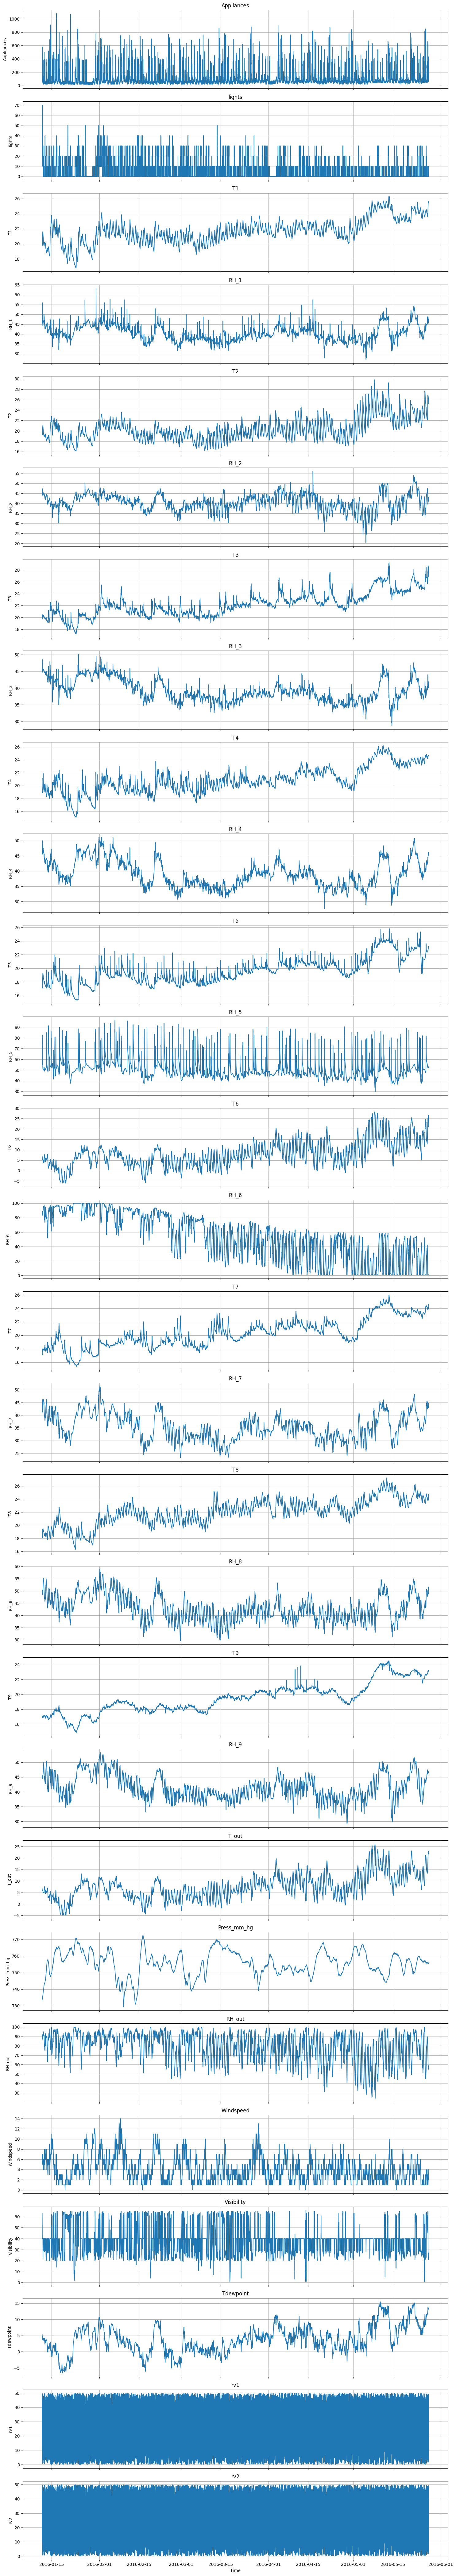

In [8]:
# visualize all numerical columns
num_cols = df.select_dtypes(include="number").columns

n = len(num_cols)

# Create vertical stack of subplots
fig, axes = plt.subplots(n, 1, figsize=(15, 3*n), sharex=True)

for i, col in enumerate(num_cols):
    axes[i].plot(df[col], color='tab:blue')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel(col)
    axes[i].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

Some features include seasonal effects. Fortunately, XGB and LightGBM can handle this.

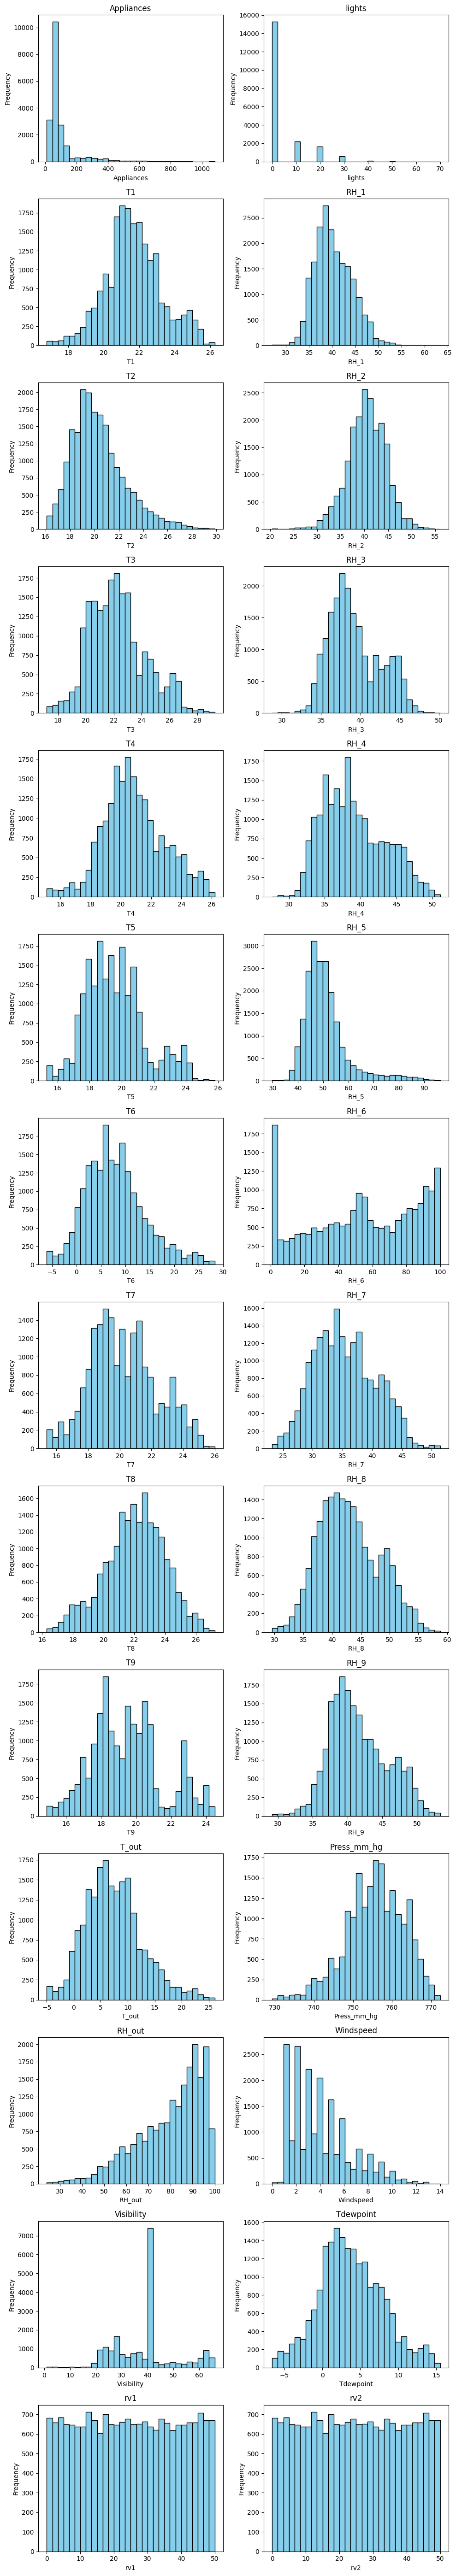

In [9]:
# Plot histogram for all numerical columns
cols_per_row = 2
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 4*rows))
axes = axes.flatten()  # flatten for easy iteration

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Define some helper functions

In [10]:
def half_month_rolling_splits(df, min_train_half_months=1):
    """
    Expanding-window rolling splits by HALF MONTH using time order.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with a DatetimeIndex
    min_train_half_months : int
        Minimum number of half-month periods to use for training

    Yields
    ------
    train_idx : np.ndarray
        Indices for training set
    val_idx : np.ndarray
        Indices for validation set
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a pandas DatetimeIndex")

    df = df.sort_index()

    # Create (year, month) groups
    df["_year_month"] = df.index.to_period("M")

    half_periods = []

    for _, group in df.groupby("_year_month"):
        n = len(group)
        if n < 2:
            continue  # skip tiny months

        mid = n // 2
        half_periods.append(group.index[:mid])
        half_periods.append(group.index[mid:])

    # Rolling expanding window over half-months
    for i in range(min_train_half_months, len(half_periods)):
        train_idx = df.index.get_indexer(
            np.concatenate(half_periods[:i])
        )
        val_idx = df.index.get_indexer(half_periods[i])

        yield train_idx, val_idx

    df.drop(columns="_year_month", inplace=True)


In [11]:
def get_feature_importance_df(model, feature_names):
    importances = model.feature_importances_
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    return fi_df

def plot_feature_importances(fi_df, model_name="Model", top_n=None, figsize=(8, 6)):
    if top_n is not None:
        fi_df = fi_df.head(top_n)

    plt.figure(figsize=figsize)
    plt.barh(fi_df["feature"], fi_df["importance"])
    plt.gca().invert_yaxis() # highest importance at top
    plt.xlabel("Importance")
    plt.title(f"{model_name} Feature Importances")
    plt.tight_layout()
    plt.show()

# Part 2. Feature Engineering

## 2.1. Target feature

In [12]:
# target feature
target = df["Appliances"]
target.describe()

# mean > median
# right skewed kurtosis

,Appliances
count,19735.000000
mean,97.694958
std,102.524891
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


Kurtosis: 13.66409667104885


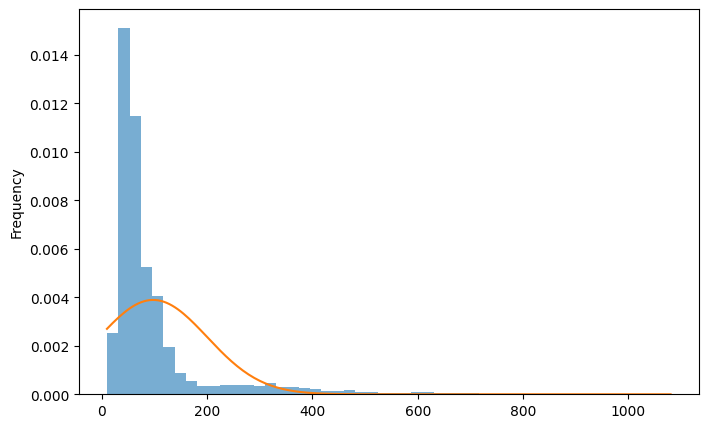

In [13]:
# check by histogram plot
print(f'Kurtosis: {kurtosis(target)}')

target.dropna().plot(
    kind='hist',
    bins=50,
    density=True,
    alpha=0.6,
    figsize=(8,5)
)

mu = target.mean()
sigma = target.std()

xx = np.linspace(target.min(), target.max(), 200)
plt.plot(xx, norm.pdf(xx, mu, sigma))
plt.show()

# distribution has a very long tail

Kurtosis: 1.5874151756782133


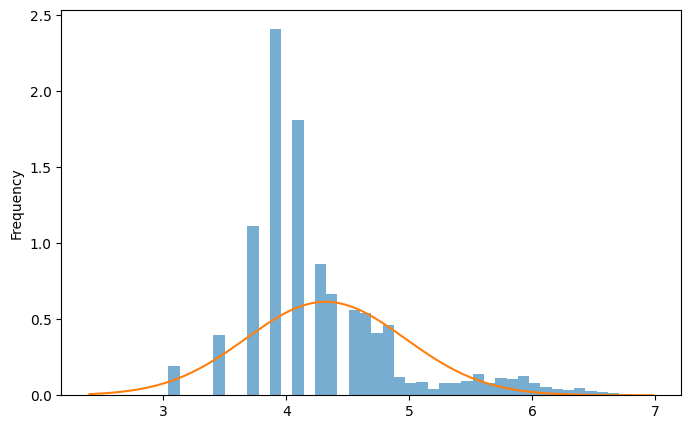

In [14]:
# apply log transformation and check again
log_target = np.log1p(target)

print(f'Kurtosis: {kurtosis(log_target)}')

log_target.dropna().plot(
    kind='hist',
    bins=50,
    density=True,
    alpha=0.6,
    figsize=(8,5)
)

mu = log_target.mean()
sigma = log_target.std()

xx = np.linspace(log_target.min(), log_target.max(), 200)
plt.plot(xx, norm.pdf(xx, mu, sigma))
plt.show()
# looks better

## 2.2. Time

In [15]:
# extract basic time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_month'] = df.index.day

# weekend or not
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# part of the day
conditions = [
    (df['hour'] >= 6) & (df['hour'] < 12),
    (df['hour'] >= 12) & (df['hour'] < 18),
    (df['hour'] >= 18) & (df['hour'] < 24)
]

choices = [0, 1, 2]  # morning, afternoon, evening

df['time_period'] = np.select(conditions, choices, default=3) # night

In [16]:
# to encode periodic time features
# hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# day of month
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 30)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 30)


## 2.3. Train test split

In [17]:
# define target feature and predictive features and split to train and test
# remove random variables rv1 and rv2
# because XGB and LightGBM can handle overfitting by tuning hyperparameters.

X = df.drop(columns=['Appliances', 'rv1', 'rv2'])
y = np.log1p(df['Appliances'])
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
# save for later use
joblib.dump(
    y_test_full,
    "y_test_full.joblib"
)

['y_test_full.joblib']

In [19]:
files.download('y_test_full.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
X_train_full.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,is_weekend,time_period,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,0,1,-0.965926,-0.258819,0.0,1.0,0.5,0.866025,0.743145,-0.669131
2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,0,1,-0.965926,-0.258819,0.0,1.0,0.5,0.866025,0.743145,-0.669131
2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,0,1,-0.965926,-0.258819,0.0,1.0,0.5,0.866025,0.743145,-0.669131
2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,0,1,-0.965926,-0.258819,0.0,1.0,0.5,0.866025,0.743145,-0.669131
2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,0,1,-0.965926,-0.258819,0.0,1.0,0.5,0.866025,0.743145,-0.669131


In [21]:
y_train_full.head()

,Appliances
date,
2016-01-11 17:00:00,4.110874
2016-01-11 17:10:00,4.110874
2016-01-11 17:20:00,3.931826
2016-01-11 17:30:00,3.931826
2016-01-11 17:40:00,4.110874


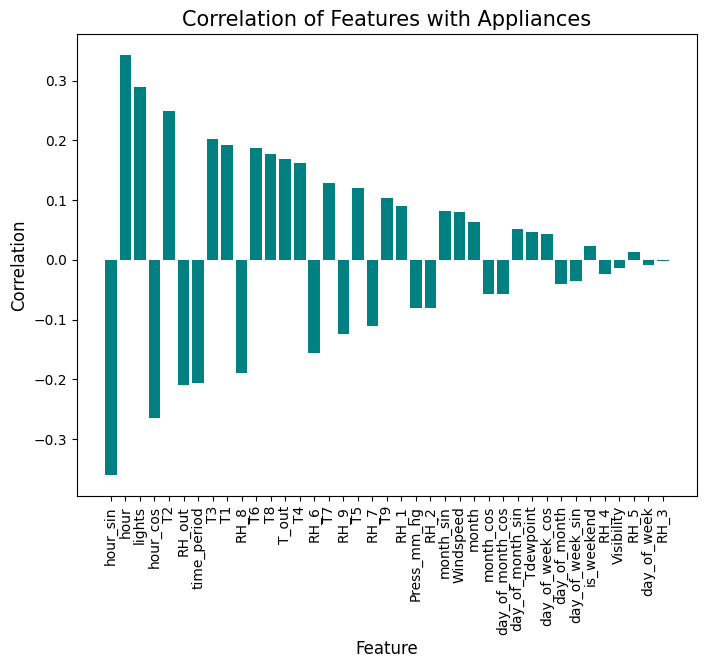

In [22]:
# correlation with target variable
X_train_copy = X_train_full.copy()
X_train_copy["target"] = y_train_full

# Calculate correlation of each feature with target
correlations_init = (
    X_train_copy
    .corr()["target"]
    .drop("target")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

# make a plot
plt.figure(figsize=(8,6))
plt.bar(x=list(correlations_init.index), height=list(correlations_init.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Appliances', fontsize=15)
plt.show()

In [23]:
correlations_init.head(10)

,target
hour_sin,-0.360559
hour,0.342418
lights,0.288677
hour_cos,-0.265046
T2,0.249513
RH_out,-0.208845
time_period,-0.205408
T3,0.202113
T1,0.191903
RH_8,-0.189830


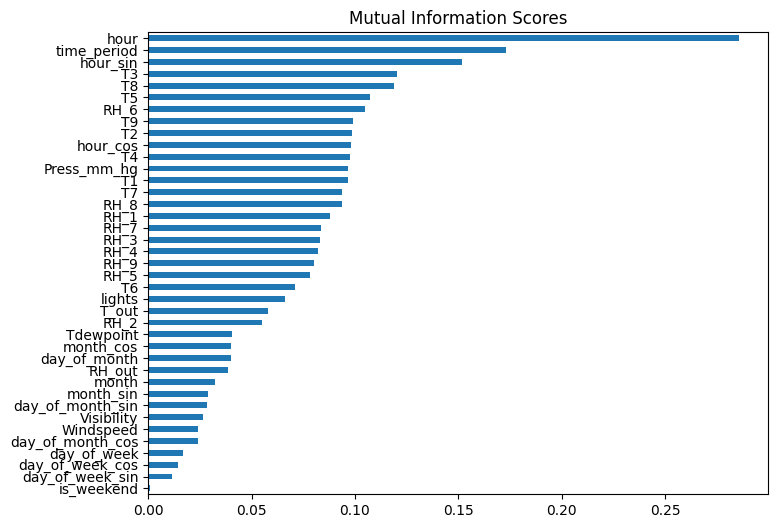

In [24]:
# calculate MI
mi_score_init = mutual_info_regression(X_train_full, y_train_full, random_state=42)

# convert to pandas Series
mi_score_init = pd.Series(mi_score_init, index=X_train_full.columns)

# sort
mi_score_init = mi_score_init.sort_values(ascending=False)

# plot
mi_score_init.plot(kind='barh', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Mutual Information Scores")
plt.show()

In [25]:
# Normalize each score
corr_norm_init = correlations_init.abs() / correlations_init.abs().max()
mi_norm_init = mi_score_init / mi_score_init.max()

# Compute average score
average_score_init = (corr_norm_init + mi_norm_init) / 2
average_score_init = average_score_init.sort_values(ascending=False)

# Convert to dataframe
average_score_df_init = average_score_init.to_frame(name="Score")
print(average_score_df_init)

# based on average score to choose features to transform
# threshold = 0.3

                     Score
hour              0.974844
hour_sin          0.765565
time_period       0.587639
hour_cos          0.538922
T2                0.518726
lights            0.516094
T3                0.491313
T8                0.453012
T1                0.435429
RH_8              0.427146
RH_6              0.400236
T4                0.394734
T6                0.383181
RH_out            0.357549
T5                0.354544
T7                0.343127
T_out             0.334071
T9                0.316330
RH_9              0.312614
RH_7              0.300770
Press_mm_hg       0.282337
RH_1              0.278387
RH_2              0.208702
RH_4              0.175830
month_sin         0.162636
RH_5              0.155370
Windspeed         0.152888
month_cos         0.150331
RH_3              0.147088
month             0.143807
Tdewpoint         0.134968
day_of_month      0.126194
day_of_month_cos  0.122007
day_of_month_sin  0.120794
day_of_week_cos   0.084958
day_of_week_sin   0.068497
V

In [26]:
# Filter features with Score > 0.3 and name starting with "T" - Temperature or "RH_" - Humidity
num_selected_features = [
    feat for feat, score in average_score_df_init["Score"].items()
    if score > 0.2 and (feat.startswith("T") or feat.startswith("RH_"))
]
print(num_selected_features)

['T2', 'T3', 'T8', 'T1', 'RH_8', 'RH_6', 'T4', 'T6', 'RH_out', 'T5', 'T7', 'T_out', 'T9', 'RH_9', 'RH_7', 'RH_1', 'RH_2']


In [27]:
# add Press_mm_hg
num_selected_features.append("Press_mm_hg")

## 2.4. Lights

In [28]:
# from the histogram, light is a discrete feature
print(df['lights'].unique())

[30 40 50 70 60 10 20  0]


In [29]:
def expanding_target_encoding_mean(df, cat_col, target_col, global_prior=None):
    """
    Expanding (past-only) target encoding for time series.
    Each row is encoded using only past rows.
    """

    df = df.copy()
    df = df.sort_index()

    if global_prior is None:
        global_prior = df[target_col].mean()

    # Running sums and counts per category
    cat_sum = {}
    cat_count = {}

    encoded = []

    for _, row in df.iterrows():
        cat = row[cat_col]

        if cat in cat_count:
            encoded.append(cat_sum[cat] / cat_count[cat])
        else:
            encoded.append(global_prior)

        # update after encoding
        y_val = row[target_col]
        cat_sum[cat] = cat_sum.get(cat, 0.0) + y_val
        cat_count[cat] = cat_count.get(cat, 0) + 1

    df[f"{cat_col}_te"] = encoded
    return pd.Series(encoded, index=df.index, name=f"{cat_col}_te_mean")


In [30]:
# Use in hafl month-based CV
X_train_folds = []
X_val_folds = []
y_train_folds = []
y_val_folds = []

# training dataset
df_train = X_train_full.copy()
df_train["y"] = y_train_full.values

for train_idx, val_idx in half_month_rolling_splits(df_train):
    X_train, X_val = X_train_full.iloc[train_idx].copy(), X_train_full.iloc[val_idx].copy()
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    # Combine features + target for encoding
    train_df = X_train.assign(y=y_train)

    # Expanding target encoding on training data
    te_series = expanding_target_encoding_mean(train_df, cat_col="lights", target_col="y")
    X_train["lights_te_mean"] = te_series

    # Map encoding to validation (use last value per category from training)
    last_te = te_series.groupby(train_df["lights"]).last()
    global_mean = y_train.mean()
    X_val["lights_te_mean"] = X_val["lights"].map(last_te).fillna(global_mean)

    # Append to lists
    X_train_folds.append(X_train)
    X_val_folds.append(X_val)
    y_train_folds.append(y_train)
    y_val_folds.append(y_val)

In [31]:
def expanding_target_encoding_median(df, cat_col, target_col, global_prior=None):
    """
    Expanding (past-only) target encoding for time series using median.
    Each row is encoded using only past rows.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame sorted by time (DatetimeIndex or monotonic index)
    cat_col : str
        Name of categorical column to encode
    target_col : str
        Name of target column
    global_prior : float, optional
        Fallback value for unseen categories / first row. Default = median(target_col)

    Returns
    -------
    pd.Series
        Target-encoded column
    """
    df = df.copy().sort_index()

    if global_prior is None:
        global_prior = df[target_col].median()

    # Store past values per category
    cat_values = {}
    encoded = []

    for _, row in df.iterrows():
        cat = row[cat_col]

        if cat in cat_values and len(cat_values[cat]) > 0:
            encoded.append(np.median(cat_values[cat]))
        else:
            encoded.append(global_prior)

        # update AFTER encoding
        cat_values.setdefault(cat, []).append(row[target_col])

    return pd.Series(encoded, index=df.index, name=f"{cat_col}_te_median")

In [32]:
# Function to add expanding median target encoding to existing folds
def add_expanding_median_te_to_folds(
    X_train_folds,
    X_val_folds,
    y_train_folds,
    cat_col: str,
    new_col_name: str
):
    """
    Add expanding target encoding (median) of a categorical column to existing folds.

    Parameters
    ----------
    X_train_folds, X_val_folds : list of pd.DataFrame
        Existing folds
    y_train_folds : list of pd.Series
        Target folds
    cat_col : str
        Categorical column to encode
    new_col_name : str
        Name of the new encoded column
    """
    for i in range(len(X_train_folds)):
        X_tr = X_train_folds[i].copy()
        X_val = X_val_folds[i].copy()
        y_tr = y_train_folds[i]

        # Reconstruct fold with target for encoding
        train_df = X_tr.assign(y=y_tr.values)

        # Expanding median target encoding
        te_series = expanding_target_encoding_median(
            train_df, cat_col=cat_col, target_col="y"
        )
        X_tr[new_col_name] = te_series

        # Map encoding to validation using last known value per category
        last_te = te_series.groupby(train_df[cat_col]).last()
        global_median = y_tr.median()
        X_val[new_col_name] = X_val[cat_col].map(last_te).fillna(global_median)

        # Update the folds
        X_train_folds[i] = X_tr
        X_val_folds[i] = X_val

In [33]:
# target encoding using median
add_expanding_median_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="lights",
    new_col_name="lights_te_median"
)

## 2.5. Time Period

In [34]:
# Parts of the day
print(df['time_period'].unique()) # morning, afternoon, evening, night

[1 2 3 0]


In [35]:
# Function to add mean expanding target encoding to existing folds
def add_expanding_mean_te_to_folds(
    X_train_folds,
    X_val_folds,
    y_train_folds,
    cat_col: str,
    new_col_name: str
):
    """
    Add expanding target encoding (mean) of a categorical column to existing folds.

    Parameters
    ----------
    X_train_folds, X_val_folds : list of pd.DataFrame
        Existing folds
    y_train_folds : list of pd.Series
        Target folds
    cat_col : str
        Categorical column to encode
    new_col_name : str
        Name of the new encoded column
    """
    for i in range(len(X_train_folds)):
        X_tr = X_train_folds[i].copy()
        X_val = X_val_folds[i].copy()
        y_tr = y_train_folds[i]

        # Reconstruct fold with target for encoding
        train_df = X_tr.assign(y=y_tr.values)

        # Expanding mean target encoding
        te_series = expanding_target_encoding_mean(
            train_df, cat_col=cat_col, target_col="y"
        )
        X_tr[new_col_name] = te_series

        # Map encoding to validation using last known value per category
        last_te = te_series.groupby(train_df[cat_col]).last()
        global_mean = y_tr.mean()
        X_val[new_col_name] = X_val[cat_col].map(last_te).fillna(global_mean)

        # Update the folds
        X_train_folds[i] = X_tr
        X_val_folds[i] = X_val

In [36]:
# target encoding using mean
add_expanding_mean_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="time_period",
    new_col_name="time_period_te_mean"
)

In [37]:
# target encoding using median
add_expanding_median_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="time_period",
    new_col_name="time_period_te_median"
)

## 2.6. Hour

In [38]:
# target encoding using mean
add_expanding_median_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="hour",
    new_col_name="hour_te_median"
)

In [39]:
# target encoding using median
add_expanding_mean_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="hour",
    new_col_name="hour_te_mean"
)

## 2.7. Month

Month's average score calculated above is not greater than 0.3. However, the month may be informative because weather changes between months affect electricity consumption.

In [40]:
# target encoding using mean
add_expanding_mean_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="month",
    new_col_name="month_te_mean"
)

In [41]:
# target encoding using median
add_expanding_median_te_to_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    cat_col="month",
    new_col_name="month_te_median"
)

Check for day of week

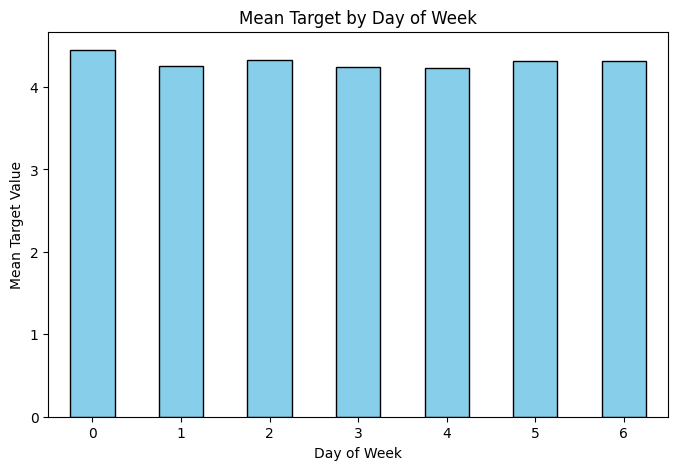

In [42]:
# Combine X and y
df_1 = X_train.copy()
df_1["target"] = y_train.values

# Group by day_of_week and compute mean target
target_by_day = df_1.groupby("day_of_week")["target"].mean()

# Plot
plt.figure(figsize=(8,5))
target_by_day.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Day of Week")
plt.ylabel("Mean Target Value")
plt.title("Mean Target by Day of Week")
plt.xticks(rotation=0)
plt.show()

# No big difference in mean of target value between days of week
# No need to tranform more

## 2.8. Temperature and Humidity in rooms

In [43]:
def bin_and_encode_all_numeric_folds(
    X_train_folds,
    X_val_folds,
    y_train_folds,
    num_cols_to_bin,
    n_bins=4,
    method="mean"
):
    """
    For each fold:
    1) Convert numeric columns to categorical bins (quantile-based, train-only)
    2) Apply expanding target encoding (mean or median) to ALL binned columns
    3) Add encoded columns to existing folds (leakage-free)

    Parameters
    ----------
    X_train_folds, X_val_folds : list of pd.DataFrame
        Existing train / validation folds
    y_train_folds : list of pd.Series
        Target folds
    num_cols_to_bin : list[str]
        Numeric columns to bin and encode
    n_bins : int
        Number of quantile bins
    method : {"mean", "median"}
        Target encoding statistic
    """

    for i in range(len(X_train_folds)):
        X_tr = X_train_folds[i].copy()
        X_val = X_val_folds[i].copy()
        y_tr = y_train_folds[i]

        # BIN NUMERIC COLUMNS (train-only)
        binned_cols = []

        for col in num_cols_to_bin:
            bin_col = f"{col}_bin"

            # Create bins from TRAIN only
            X_tr[bin_col] = pd.qcut(
                X_tr[col],
                q=n_bins,
                labels=False,
                duplicates="drop"
            )

            # Apply same bins to validation
            X_val[bin_col] = pd.qcut(
                X_val[col],
                q=n_bins,
                labels=False,
                duplicates="drop"
            )

            binned_cols.append(bin_col)

        # EXPANDING TARGET ENCODING
        train_df = X_tr.assign(y=y_tr.values)

        for bin_col in binned_cols:
            enc_col = f"{bin_col}_te_{method}"

            if method == "mean":
                te = expanding_target_encoding_mean(
                    train_df, cat_col=bin_col, target_col="y"
                )
                global_stat = y_tr.mean()

            elif method == "median":
                te = expanding_target_encoding_median(
                    train_df, cat_col=bin_col, target_col="y"
                )
                global_stat = y_tr.median()

            else:
                raise ValueError("method must be 'mean' or 'median'")

            # Add to train
            X_tr[enc_col] = te

            # Leakage-free mapping to validation
            last_te = te.groupby(train_df[bin_col]).last()
            X_val[enc_col] = X_val[bin_col].map(last_te).fillna(global_stat)

        # UPDATE FOLDS
        X_train_folds[i] = X_tr
        X_val_folds[i] = X_val


In [44]:
# target encoding using mean
bin_and_encode_all_numeric_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    num_cols_to_bin=num_selected_features,
    n_bins=3,
    method="mean"
)

In [45]:
# target encoding using median
bin_and_encode_all_numeric_folds(
    X_train_folds=X_train_folds,
    X_val_folds=X_val_folds,
    y_train_folds=y_train_folds,
    num_cols_to_bin=num_selected_features,
    n_bins=3,
    method="median"
)

In [46]:
# Drop all binned categorical columns (ending with '_bin') after encoding
for i in range(len(X_train_folds)):
    # Identify binned columns in the current fold
    binned_cols = [col for col in X_train_folds[i].columns if col.endswith("_bin")]

    # Drop from both train and val
    X_train_folds[i].drop(columns=binned_cols, inplace=True)
    X_val_folds[i].drop(columns=binned_cols, inplace=True)


In [47]:
# save folds for later use
joblib.dump(
    {
        "X_train_folds": X_train_folds,
        "y_train_folds": y_train_folds,
        "X_val_folds": X_val_folds,
        "y_val_folds": y_val_folds,
    },
    "cv_folds.joblib"
)

['cv_folds.joblib']

In [48]:
files.download('cv_folds.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.9. Correlation and MI score for folds

In [49]:
# number of features in each fold
print("All features across folds:")
print(X_train_folds[0].columns.tolist())

print("Shape of each fold:")
X_train_folds[0].shape

All features across folds:
['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'hour', 'day_of_week', 'month', 'day_of_month', 'is_weekend', 'time_period', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_month_sin', 'day_of_month_cos', 'lights_te_mean', 'lights_te_median', 'time_period_te_mean', 'time_period_te_median', 'hour_te_median', 'hour_te_mean', 'month_te_mean', 'month_te_median', 'T2_bin_te_mean', 'T3_bin_te_mean', 'T8_bin_te_mean', 'T1_bin_te_mean', 'RH_8_bin_te_mean', 'RH_6_bin_te_mean', 'T4_bin_te_mean', 'T6_bin_te_mean', 'RH_out_bin_te_mean', 'T5_bin_te_mean', 'T7_bin_te_mean', 'T_out_bin_te_mean', 'T9_bin_te_mean', 'RH_9_bin_te_mean', 'RH_7_bin_te_mean', 'RH_1_bin_te_mean', 'RH_2_bin_te_mean', 'Press_mm_hg_bin_te_mean', 'T2_bin_te_median', 'T3_bin_te_median', 'T8_bin_t

(1461, 83)

In [50]:
# Compute MI fold by fold
mi_scores_folds = []

for X_train, y_train in zip(X_train_folds, y_train_folds):
    # Make sure all columns are numeric (MI requires numeric input)
    X_train_numeric = X_train.select_dtypes(include=[np.number])

    # Compute MI between each feature and target
    mi = mutual_info_regression(X_train_numeric, y_train, random_state=42)

    # Convert to Series with feature names
    mi_series = pd.Series(mi, index=X_train_numeric.columns)

    mi_scores_folds.append(mi_series)

# Concatenate MI from all folds
mi_df = pd.concat(mi_scores_folds, axis=1)

# Take mean across folds
mi_mean = mi_df.mean(axis=1).sort_values(ascending=False)

print("Top features by MI:")
print(mi_mean.head(10))


Top features by MI:
time_period_te_mean    0.321039
hour                   0.303419
lights_te_mean         0.284576
hour_te_mean           0.278137
hour_te_median         0.220189
T3_bin_te_mean         0.204954
Press_mm_hg            0.197903
T2_bin_te_mean         0.190331
time_period            0.188593
RH_8_bin_te_mean       0.181801
dtype: float64


In [51]:
# Store correlation series for each fold
correlations_folds = []

for X_train, y_train in zip(X_train_folds, y_train_folds):
    # Combine X and y temporarily for correlation
    df_fold = X_train.copy()
    df_fold["target"] = y_train.values

    # Compute correlation of all features with target
    corr = df_fold.corr()["target"].drop("target")

    correlations_folds.append(corr)

# Concatenate all correlations into a DataFrame
corr_df = pd.concat(correlations_folds, axis=1)

# Take mean across folds
mean_corr = corr_df.mean(axis=1)

# Sort by absolute value
mean_corr = mean_corr.sort_values(key=lambda s: s.abs(), ascending=False)

print(mean_corr.head(10))

hour_te_mean             0.491504
hour_te_median           0.458440
lights_te_mean           0.438522
lights_te_median         0.429272
lights                   0.402298
time_period_te_mean      0.400210
time_period_te_median    0.367706
hour                     0.355512
hour_sin                -0.350227
T2_bin_te_mean           0.231880
dtype: float64


# Part 3. Training model on folds and Feature Selection

RMSE was chosen for model training because we have already transformed the target variable into a logarithmic value.
MAE is used as a complementary metric to assess model performance on test set.

In [52]:
from sklearn.base import clone

def rolling_cv_xgboost_random_rmse(
    X_train_folds,
    y_train_folds,
    X_val_folds,
    y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1,
):
    """
    Rolling CV for XGBoost using PRE-SPLIT and PRE-ENGINEERED folds.
    Hyperparameters are optimized for RMSE.

    Returns
    -------
    best_model : XGBRegressor
    random_search : RandomizedSearchCV
    cv_results_df : pd.DataFrame
    """

    # Concatenate folds (required by sklearn)

    X_all = pd.concat(
        [*X_train_folds, *X_val_folds],
        axis=0,
        ignore_index=True
    )

    y_all = pd.concat(
        [*y_train_folds, *y_val_folds],
        axis=0,
        ignore_index=True
    )

    # Build rolling / expanding CV splits

    cv_splits = []
    cursor = 0

    for X_tr, X_va in zip(X_train_folds, X_val_folds):
        n_tr = len(X_tr)
        n_va = len(X_va)

        val_start = cursor + n_tr
        val_end = val_start + n_va

        train_idx = np.arange(0, val_start)
        val_idx = np.arange(val_start, val_end)

        cv_splits.append((train_idx, val_idx))

        cursor += n_tr + n_va

    # Base model

    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=n_jobs
    )

    # Hyperparameter space

    param_distributions = {
        "max_depth": [5, 6, 7],
        "min_child_weight": [50, 70, 90],
        "learning_rate": [0.05, 0.055],
        "n_estimators": [600, 650, 700],
        "gamma": [0.1, 0.2, 0.3],
        "subsample": [0.7, 0.75, 0.8],
        "colsample_bytree": [0.5, 0.55, 0.6],
        "reg_alpha": [0.5, 0.7, 1.0],
        "reg_lambda": [1.0, 1.2, 1.5],
    }

    # Randomized search

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )

    random_search.fit(X_all, y_all)

    best_model = random_search.best_estimator_
    best_rmse = -random_search.best_score_

    # Compute MAE manually over folds

    mae_list = []

    for X_tr, y_tr, X_va, y_va in zip(
      X_train_folds, y_train_folds, X_val_folds, y_val_folds
    ):
      model = clone(best_model)
      model.fit(X_tr, y_tr)
      y_pred = model.predict(X_va)
      mae_list.append(mean_absolute_error(y_va, y_pred))

    mean_mae = np.mean(mae_list)

    # Output

    cv_results_df = pd.DataFrame({
        "cv_rmse": [best_rmse],
        "cv_mae": [mean_mae]
    })

    print("Best parameters:", random_search.best_params_)
    print(f"Best CV RMSE: {best_rmse:.4f}")
    print(f"Best CV MAE:  {mean_mae:.4f}")

    return best_model, random_search, cv_results_df


In [53]:
best_xgb, xgb_random, _ = rolling_cv_xgboost_random_rmse(
    X_train_folds,
    y_train_folds,
    X_val_folds,
    y_val_folds,
    n_iter=20,
    n_jobs=1,
    verbose=1
)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
Best parameters: {'subsample': 0.75, 'reg_lambda': 1.0, 'reg_alpha': 0.7, 'n_estimators': 700, 'min_child_weight': 70, 'max_depth': 7, 'learning_rate': 0.055, 'gamma': 0.1, 'colsample_bytree': 0.55}
Best CV RMSE: 0.4377
Best CV MAE:  0.4284


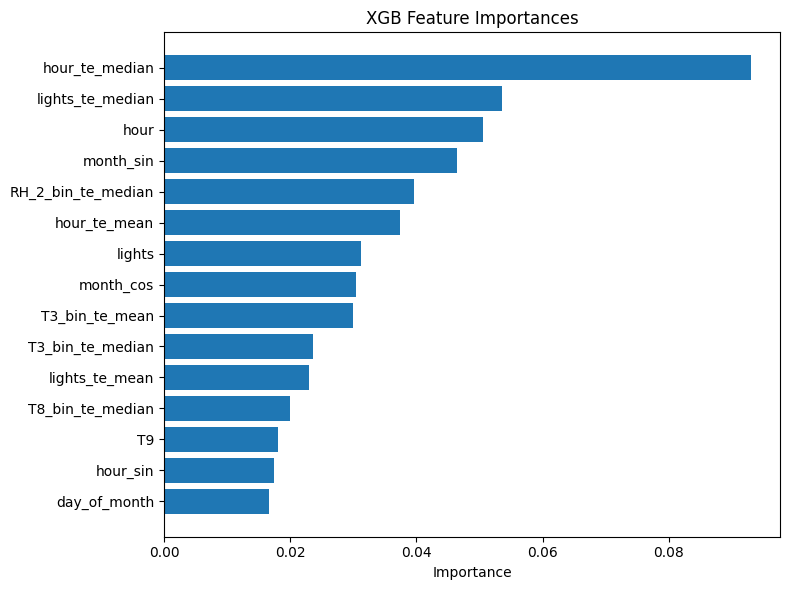

In [62]:
# feature importance
feature_importance_xgb = get_feature_importance_df(best_xgb, X_train_folds[0].columns.tolist())
plot_feature_importances(feature_importance_xgb, model_name="XGB", top_n=15)

In [63]:
# Get feature importance
booster = best_xgb.get_booster()

fi_dict = booster.get_score(importance_type='gain')

fi = pd.Series(fi_dict)

# Reindex feature importance, fill missing with 0 of feature importance from model
all_features = X_train_folds[0].columns.tolist()

fi = fi.reindex(all_features, fill_value=0)

# Sort descending
fi_sorted = fi.sort_values(ascending=False)

print(fi_sorted.head(10))

hour_te_median        51.676891
lights_te_median      29.759747
hour                  28.061409
month_sin             25.812519
RH_2_bin_te_median    21.979490
hour_te_mean          20.783098
lights                17.375137
month_cos             16.878042
T3_bin_te_mean        16.668182
T3_bin_te_median      13.080514
dtype: float64


In [64]:
# Normalize each measure to [0, 1] for comparability
mi_norm = mi_mean / mi_mean.max()
corr_norm = mean_corr.abs() / mean_corr.abs().max()
fi_norm = fi_sorted/ fi_sorted.max()

# realign everything to the same index order
corr_norm = corr_norm.loc[mi_norm.index]
fi_norm = fi_norm.loc[mi_norm.index]

# Average the normalized scores
average_score = (fi_norm + corr_norm + mi_norm) / 3

# Convert to DataFrame and rename column
average_score_df = average_score.to_frame(name="Score")

# Sort descending
average_score_df = average_score_df.sort_values("Score", ascending=False)

print(average_score_df.head(10))

                          Score
hour_te_median         0.872864
hour_te_mean           0.756179
hour                   0.737149
lights_te_mean         0.675427
time_period_te_mean    0.637241
lights_te_median       0.617207
lights                 0.524927
hour_sin               0.471702
T3_bin_te_mean         0.469347
time_period_te_median  0.461269


In [65]:
average_score_df.tail(10)

,Score
month,0.124532
Press_mm_hg_bin_te_median,0.123288
T7_bin_te_median,0.123104
T9_bin_te_median,0.118799
is_weekend,0.103653
RH_6_bin_te_median,0.096756
RH_1_bin_te_median,0.095836
day_of_week_cos,0.092999
Windspeed,0.064317
Visibility,0.061588


Try different subsets of features

In [66]:
# Top 60 features
top60_features = average_score_df.head(60).index.tolist()

# Top 70 features
top70_features = average_score_df.head(70).index.tolist()

# Top 80 features
top80_features = average_score_df.head(80).index.tolist()


In [67]:
def create_fold_top_features(X_train_folds, X_val_folds, top_features_list):
    """
    Subset folds to keep only top features.

    Parameters
    ----------
    X_train_folds : list of pd.DataFrame
        List of training folds
    X_val_folds : list of pd.DataFrame
        List of validation folds
    top_features_list : list of str
        List of feature names to keep

    Returns
    -------
    X_train_top_folds, X_val_top_folds : list of pd.DataFrame
        Lists of folds containing only top features
    """
    X_train_top_folds = [X_train[top_features_list].copy() for X_train in X_train_folds]
    X_val_top_folds   = [X_val[top_features_list].copy() for X_val in X_val_folds]

    return X_train_top_folds, X_val_top_folds


In [68]:
# top 60 features
X_train_top60, X_val_top60 = create_fold_top_features(X_train_folds, X_val_folds, top60_features)

# train model
best_xgb_top60, xgb_random_top60, _ = rolling_cv_xgboost_random_rmse(
    X_train_top60,
    y_train_folds,
    X_val_top60,
    y_val_folds,
    n_iter=20,
    n_jobs=-1,
    verbose=1
)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.7, 'n_estimators': 650, 'min_child_weight': 50, 'max_depth': 6, 'learning_rate': 0.055, 'gamma': 0.1, 'colsample_bytree': 0.55}
Best CV RMSE: 0.4470
Best CV MAE:  0.4315


In [69]:
# top 70 features
X_train_top70, X_val_top70 = create_fold_top_features(X_train_folds, X_val_folds, top70_features)

# train model
best_xgb_top70, xgb_random_top70, _ = rolling_cv_xgboost_random_rmse(
    X_train_top70,
    y_train_folds,
    X_val_top70,
    y_val_folds,
    n_iter=20,
    n_jobs=-1,
    verbose=1
)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.7, 'n_estimators': 650, 'min_child_weight': 50, 'max_depth': 6, 'learning_rate': 0.055, 'gamma': 0.1, 'colsample_bytree': 0.55}
Best CV RMSE: 0.4296
Best CV MAE:  0.4377


In [70]:
# top 80 features
X_train_top80, X_val_top80 = create_fold_top_features(X_train_folds, X_val_folds, top80_features)

# train model
best_xgb_top80, xgb_random_top80, _ = rolling_cv_xgboost_random_rmse(
    X_train_top80,
    y_train_folds,
    X_val_top80,
    y_val_folds,
    n_iter=20,
    n_jobs=-1,
    verbose=1
)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
Best parameters: {'subsample': 0.75, 'reg_lambda': 1.0, 'reg_alpha': 0.7, 'n_estimators': 700, 'min_child_weight': 70, 'max_depth': 7, 'learning_rate': 0.055, 'gamma': 0.1, 'colsample_bytree': 0.55}
Best CV RMSE: 0.4328
Best CV MAE:  0.4222


In [125]:
# Best CV RMSE of the model with 70 best features varies deviate too much from the others.
# maybe overfitting
# choose the model with 80 features (second lowest rmse)
# define the best model
best_xgb_model = best_xgb_top80

# Part 4: Refit best model on full training set

In [126]:
# Combine features + target
train_full_df = X_train_full.copy()
train_full_df["y"] = y_train_full.values

Then do the same transformation as what we did with folds

In [127]:
def fit_expanding_target_encoding_column(
    X_train,
    y_train,
    cat_col,
    method="mean",
    target_col_name="y"
):
    """
    Fit expanding target encoding on full training data
    and return ONLY the encoded column.

    Returns
    -------
    encoded_col : pd.Series
        Target-encoded values aligned with X_train.index
    mapping : pd.Series
        Final encoding per category
    global_stat : float
        Fallback value for unseen categories
    """

    df = X_train.copy()
    df[target_col_name] = y_train.values

    # Select encoding method
    if method == "mean":
        te = expanding_target_encoding_mean(
            df,
            cat_col=cat_col,
            target_col=target_col_name
        )
        global_stat = y_train.mean()

    elif method == "median":
        te = expanding_target_encoding_median(
            df,
            cat_col=cat_col,
            target_col=target_col_name
        )
        global_stat = y_train.median()

    else:
        raise ValueError("method must be 'mean' or 'median'")

    # Final encoding per category
    mapping = te.groupby(df[cat_col]).last()

    # Build encoded column (aligned index!)
    encoded_col = (
        X_train[cat_col]
        .map(mapping)
        .fillna(global_stat)
    )

    encoded_col.name = f"{cat_col}_te_{method}"

    return encoded_col, mapping


Lights

In [128]:
lights_te_mean, lights_te_mean_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="lights",
        method="mean"
    )
)

In [129]:
lights_te_median, lights_te_median_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="lights",
        method="median"
    )
)

Time period

In [130]:
time_period_te_mean, time_period_te_mean_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="time_period",
        method="mean"
    )
)

In [131]:
time_period_te_median, time_period_te_median_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="time_period",
        method="median"
    )
)

Hour

In [132]:
hour_te_mean, hour_te_mean_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="hour",
        method="mean"
    )
)

In [133]:
hour_te_median, hour_te_median_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="hour",
        method="median"
    )
)

Month

In [134]:
month_te_mean, month_te_mean_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="month",
        method="mean"
    )
)

In [135]:
month_te_median, month_te_median_mapping = (
    fit_expanding_target_encoding_column(
        X_train_full,
        y_train_full,
        cat_col="month",
        method="median"
    )
)

Temperature and Humidiy in rooms

In [136]:
def bin_and_encode_all_numeric_full_train(
    X_train,
    y_train,
    num_cols_to_bin,
    n_bins=3,
    method="mean"
):
    """
    1) Bin numeric columns using training-only quantiles
    2) Apply expanding target encoding (mean or median)
    3) Return ONLY encoded columns + artifacts needed for test

    Returns
    -------
    encoded_df : pd.DataFrame
        Target-encoded columns for training set
    bin_edges : dict
        {col: bin edges} for applying to test data
    te_mappings : dict
        {binned_col: category -> encoding}
    global_stats : dict
        {binned_col: fallback value}
    """

    X_tr = X_train.copy()
    encoded_cols = {}
    bin_edges = {}
    te_mappings = {}
    global_stats = {}

    for col in num_cols_to_bin:
        bin_col = f"{col}_bin"
        enc_col = f"{bin_col}_te_{method}"

        # BINNING (TRAIN ONLY)
        X_tr[bin_col], edges = pd.qcut(
            X_tr[col],
            q=n_bins,
            labels=False,
            retbins=True,
            duplicates="drop"
        )
        bin_edges[col] = edges

        # EXPANDING TARGET ENCODING
        train_df = X_tr[[bin_col]].copy()
        train_df["y"] = y_train.values

        if method == "mean":
            te = expanding_target_encoding_mean(
                train_df, cat_col=bin_col, target_col="y"
            )
            global_stat = y_train.mean()

        elif method == "median":
            te = expanding_target_encoding_median(
                train_df, cat_col=bin_col, target_col="y"
            )
            global_stat = y_train.median()

        else:
            raise ValueError("method must be 'mean' or 'median'")

        # Save artifacts
        te_mappings[bin_col] = te.groupby(train_df[bin_col]).last()
        global_stats[bin_col] = global_stat

        # Build encoded column
        encoded_cols[enc_col] = (
            X_tr[bin_col]
            .map(te_mappings[bin_col])
            .fillna(global_stat)
        )

    encoded_df = pd.DataFrame(encoded_cols, index=X_train.index)

    return encoded_df, bin_edges, te_mappings, global_stats


In [137]:
# apply on list of features with Score > 0.2

X_train_enc_mean, bin_edges_mean, te_maps_mean, global_stats_mean = (
    bin_and_encode_all_numeric_full_train(
        X_train_full,
        y_train_full,
        num_selected_features,
        n_bins=3,
        method="mean"
    )
)

In [138]:
# and median
X_train_enc_median, bin_edges_median, te_maps_median, global_stats_median = (
    bin_and_encode_all_numeric_full_train(
        X_train_full,
        y_train_full,
        num_selected_features,
        n_bins=3,
        method="median"
    )
)

Refit on full training set

In [139]:
# combine all transformed features
cat_features_enc = pd.concat([lights_te_mean, lights_te_median,
                              time_period_te_mean, time_period_te_median,
                              hour_te_mean, hour_te_median,
                              month_te_mean, month_te_median,
                              ], axis = 1)

X_train_full_enc = pd.concat([X_train_full, X_train_enc_mean, X_train_enc_median, cat_features_enc], axis=1)


In [140]:
# save for later use
joblib.dump(
    X_train_full_enc,
    "X_train_full_enc.joblib"
)

['X_train_full_enc.joblib']

In [141]:
files.download('X_train_full_enc.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [142]:
# save for later use
joblib.dump(
    y_train_full,
    "y_train_full.joblib"
)

['y_train_full.joblib']

In [143]:
files.download('y_train_full.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [144]:
best_xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.55, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.055, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=70, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=-1, num_parallel_tree=None, ...)

In [145]:
best_xgb_model.fit(X_train_full_enc, y_train_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.55, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.055, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=70, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=-1, num_parallel_tree=None, ...)

# Part 5: Transforming test set

## 5.1. Lights

In [146]:
# global value of y_train
global_stat_mean = y_train.mean()
global_stat_median = y_train.median()

In [147]:
test_lights_te_mean = (
    X_test_full["lights"]
    .map(lights_te_mean_mapping)
    .fillna(global_stat_mean)
)

In [148]:
test_lights_te_median = (
    X_test_full["lights"]
    .map(lights_te_median_mapping)
    .fillna(global_stat_median)
)

In [149]:
# combine and rename them
cat_features_enc_test = pd.concat(
    [
        test_lights_te_mean.rename("lights_te_mean"),
        test_lights_te_median.rename("lights_te_median")
    ],
    axis=1
)

## 5.2. Time Period

In [150]:
test_time_period_te_mean = (
    X_test_full["time_period"]
    .map(time_period_te_mean_mapping)
    .fillna(global_stat_mean)
)

In [151]:
test_time_period_te_median = (
    X_test_full["time_period"]
    .map(time_period_te_median_mapping)
    .fillna(global_stat_median)
)

In [152]:
# combine and rename them
cat_features_enc_test = pd.concat(
    [
        cat_features_enc_test,
        test_time_period_te_mean.rename("time_period_te_mean"),
        test_time_period_te_median.rename("time_period_te_median")
    ],
    axis=1
)

## 5.3. Hour

In [153]:
test_hour_te_mean = (
    X_test_full["hour"]
    .map(hour_te_mean_mapping)
    .fillna(global_stat_mean)
)

In [154]:
test_hour_te_median = (
    X_test_full["hour"]
    .map(hour_te_median_mapping)
    .fillna(global_stat_median)
)

In [155]:
# combine and rename them
cat_features_enc_test = pd.concat(
    [
        cat_features_enc_test,
        test_hour_te_mean.rename("hour_te_mean"),
        test_hour_te_median.rename("hour_te_median")
    ],
    axis=1
)

## 5.4. Month

In [156]:
test_month_te_mean = (
    X_test_full["month"]
    .map(month_te_mean_mapping)
    .fillna(global_stat_mean)
)

In [157]:
test_month_te_median = (
    X_test_full["month"]
    .map(month_te_median_mapping)
    .fillna(global_stat_median)
)

In [158]:
# combine and rename them
cat_features_enc_test = pd.concat(
    [
        cat_features_enc_test,
        test_month_te_mean.rename("month_te_mean"),
        test_month_te_median.rename("month_te_median")
    ],
    axis=1
)

## 5.5. Temperature and Humidity in rooms

In [159]:
def apply_bin_and_encode_all_numeric_test(
    X_test,
    num_cols_to_bin,
    bin_edges,
    te_mappings,
    global_stats,
    method="mean"
):
    """
    Apply binning + target encoding to test data
    using artifacts learned from training.
    """

    encoded_cols = {}

    for col in num_cols_to_bin:
        bin_col = f"{col}_bin"
        enc_col = f"{bin_col}_te_{method}"

        # APPLY TRAINING BINS
        X_test_bin = pd.cut(
            X_test[col],
            bins=bin_edges[col],
            labels=False,
            include_lowest=True
        )

        # APPLY TRAINING ENCODING
        encoded_cols[enc_col] = (
            X_test_bin
            .map(te_mappings[bin_col])
            .fillna(global_stats[bin_col])
        )

    return pd.DataFrame(encoded_cols, index=X_test.index)


In [160]:
X_test_enc_mean = apply_bin_and_encode_all_numeric_test(
    X_test_full,
    num_selected_features,
    bin_edges=bin_edges_mean,
    te_mappings=te_maps_mean,
    global_stats=global_stats_mean,
    method="mean"
)

In [161]:
X_test_enc_median = apply_bin_and_encode_all_numeric_test(
    X_test_full,
    num_selected_features,
    bin_edges=bin_edges_median,
    te_mappings=te_maps_median,
    global_stats=global_stats_median,
    method="median"
)

# Part 6: Model Validation

In [162]:
# Final test dataset
X_test_final = pd.concat([X_test_full, X_test_enc_mean, X_test_enc_median, cat_features_enc_test], axis=1)

# remove duplicates
X_test_final = X_test_final.loc[:, ~X_test_final.columns.duplicated()]


In [163]:
# save for later use
joblib.dump(
    X_test_final,
    "X_test_final.joblib"
)

['X_test_final.joblib']

In [164]:
files.download('X_test_final.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [165]:
# make prediction
log_y_pred = best_xgb_model.predict(X_test_final)

# true value
y_pred = np.expm1(log_y_pred)

In [166]:
# compare with true value

y_pred_df = pd.DataFrame(
    {
        "log_y_true": y_test_full.values,
        "log_y_pred": log_y_pred
    },
    index=y_test_full.index
)
y_pred_df

,log_y_true,log_y_pred
date,,
2016-04-30 08:20:00,5.916202,4.444137
2016-04-30 08:30:00,6.381816,4.393514
2016-04-30 08:40:00,5.771441,4.387914
2016-04-30 08:50:00,5.739793,4.337950
2016-04-30 09:00:00,5.564520,4.385852
...,...,...
2016-05-27 17:20:00,4.615121,5.301469
2016-05-27 17:30:00,4.510860,5.317183
2016-05-27 17:40:00,5.602119,5.191607


In [167]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [172]:
# calculate rmse
rmse = rmse_score(y_test_full, log_y_pred)
print(rmse)

0.5671016892112046


In [173]:
# and mae
mae = mean_absolute_error(y_test_full, log_y_pred)
print("MAE:", mae)

MAE: 0.4410829913845008


In [174]:
# metrics from CV
val_rmse = 0.4328
val_mae =  0.4222

In [175]:
# Create DataFrame
metrics_df = pd.DataFrame(
      {
          "Cross-Validation": [val_rmse, val_mae],
          "Test set": [rmse, mae]
      },
      index=["RMSE", "MAE"]
  )

metrics_df = metrics_df.round(4)

print(metrics_df)

      Cross-Validation  Test set
RMSE            0.4328    0.5671
MAE             0.4222    0.4411


The values of the metrics are relatively consistent between cross-validation and the test set. On the test set, RMSE equals approximately 76% RMSE on CV.